We are going to start by importing some basic libraries to start working with our dataset.

- os will be used to work with folder paths, iterate between files, etc.
 
- Keras will be used to

- cv2 will do selective search on images, which is a region proposal algorithm that computes herachical groups based on colors and textures.

- Pandas will be used to create a datagrame with the image information.

- Matplotlib to show the images

- Numpy to work with the data later on easily

- Tensorflow to build the neural network

In [1]:
import os,keras,cv2 #cv2 requiered for selective search on images
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In another different script we already splitted the data from anotation and photos. However, the folders created for each format file had the whole dataset. 

To properly build, train and test our model we will need to split the data into train, validation and test. Therefore we will use a function from the splitfolders modeule which takes an input folder and splits its directories into separe directories with data fron trainin and test (optionally validation can also be selected as we did) mantaining the proportions selected. It also allows to specify a seed so our results can be reprodusable.

In [2]:
import splitfolders

splitfolders.ratio(input='DATA_SPLIT_JPG_CSV', output="DATA_SPLIT", seed=1337, ratio=(.8, 0.2))

Now into the DATA_SPLITTED folder we will have another three directories (train,validation,test). Inside each of them we will have different folders containing photos and its annotations.

Now we are going to define the iou function. This function is used to calculate the intersection over union between the testing boxes where the bacillus are located and the boxed generated by the algorithm in each image.

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

We now begin with our image proccesing part. We will be using selective search to look for features in our images. These features will be sections of images with labels 0 and 1 for indicating if the segment is a bacillus or not.

In [41]:
train_images=[]
train_labels=[]

photos = "DATA_SPLIT/train/photos"
annotations = "DATA_SPLIT/train/anotations"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for e,i in enumerate(os.listdir(annotations)):
    try:
        if i.startswith("tuberculosis"):
            filename=i.split(".")[0]+".jpg"
            image=cv2.imread(os.path.join(photos,filename))
            df=pd.read_csv(os.path.join(annotations,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            #image=cv2.medianBlur(image,3)
            image[:,:,0]=cv2.equalizeHist(image[:,:,0])
            image[:,:,1]=cv2.equalizeHist(image[:,:,1])
            image[:,:,2]=cv2.equalizeHist(image[:,:,2])

            #border detecion
            img_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            gauss = cv2.GaussianBlur(img_grey, (5,5), 0)
            canny = cv2.Canny(gauss, 0, 140)
            (contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image,contornos,-1,(0,0,255), 2)
            ################

            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            for e,result in enumerate(ssresults):
                if e<8000 and flag ==0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

inside
inside
inside
inside
inside
inside
inside
inside
inside


Once the step above is completed we will have one object conaining all the images that we are going to use for training. Notice that as we restricted it to 30 images for both false and true objects the dataset for predicting the outcome will be more or less well-balanced.

Within the train_images we have all the sections from the real images whereas in train_label we have a list including the index of those images that are background (0) or bacillus (1).

To work easily with these objects we are going to convert them to numpy objects.

In [42]:
X_new_0 = np.array(train_images)
y_new_0 = np.array(train_labels)

X_new_0.shape
y_new_0.shape

np.save("X_new_fulleq_bd_2.npy",X_new_0)
np.save("y_new_fulleq_bd_2.npy",y_new_0)


In [10]:
X_new=np.load("variables/X_new_fulleq_bd_2.npy")
y_new=np.load("variables/y_new_fulleq_bd_2.npy")

Code for leveling the number of positive and negative samples for training the model.

In [77]:
a=np.where(y_new==1)
a=np.array(a)
index_1=np.random.randint(0,a.size,a.size)

b=np.where(y_new==0)
b=np.array(b)


index_2=np.random.choice(b[0,],2000)

index=np.concatenate((index_1,index_2))

X_new=X_new[index]
X_new.shape
y_new=y_new[index]

The selective search is a heavy process for this big amount of photos. Therefore, we will save the information collected into nompy objects so we can easily try reproduce results and train different models.

data in 0-1 range

In [11]:
X_new=X_new/255

In [4]:
for i in range(X_new.shape[0]):
    X_new[i,:,:,:]=X_new[i,:,:,:]/255


Now we will take advantage of the framework Keras, which is one of the most used for deep learning projects.

First we will import the function Dense from keras.layers, which implements the activation function of the network.

Then, Models groups all the layers into a single object with training and inference features.

With optimizers we can make the model to learn from itself.

IMageDataGenerator not used

Then keras.application includes models that have already pre-trained weights. In pur case we eill used VGG16.

- include_top: whether to include the 3 fully-connected layers at the top of the network.
- weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.


In [17]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet')
vggmodel.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Once we have our model selected we are going to do transfer learning on the image weight. 

Transferlearning consists on taking advantage on a model that is already traind with much more data and take those layers that can be improved for our problem. This way we will train the layers selected to obtain better results. Therefore we will freeze the first 15 layers of the model and not train their weights.

In [18]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False


Now we select the second last layer of the model and add two unit softmax dense layer as we have two classes to predict (bacillus,background). So we remove the last layer of the VGG2 model which is made to predict 1000 classes.

In [19]:
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input, predictions)


Now as the optimization algorithm we will use the Adaptive Movement Estimation algorith, also refered as ADAM. This algorithm brigns many advantages as it adapts the parameter learning rates based on the average of the second moments of the gradientes (the uncentered variance).

We will set the learning rate as 0.001 and the default values for the others parameters in tensorflow keras are:

- beta1=0.9
- beta2=0.999
- epsilon=1e-08
- decay = 0

In [20]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)


Try to give more importance to one classwhile training the cnn.

In [48]:
neg, pos = np.bincount(y_new)

total=neg+pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

Now with the method compile we can configure the model for training

In [21]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["Recall"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

After creating the model we need to split the dataset into train and test. However, before that we need to one-hot encode the label. Therefore we will use MyLabelBinarizer() function and train_test_split to devide the dataset.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

Now we split both predictors and response in test and training with the function train_test_split from sklearn.

To make sure that the dimensions are the ones we wanted we print it.

In [23]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.15)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

: 

: 

In order to increase the data that we have we are going to include rotations and flip the image. This way we can make it possible to recognice bacillous independently on its orientation.

In [54]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

Now we are going to train the model with the data given. However, before doing that we are going to implement a few methods that will make us get a faster solution. Early stopping will stop the training whenevver a metric has stopped improving.

On the other hand, ModelCheckpoint will take the already computed weights from the model. These weights are already computed as we said before. To get them we use this function.

In [55]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

Now we fit our model with the data augmented and plot the results

In [ ]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [57]:
model_final.save("RCNN_fulleq_bd_2.h5")

In [3]:
model_final=keras.models.load_model('RCNN_fulleq_bd_2.h5')

2022-06-21 18:01:39.416857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Small test

In [ ]:
for image in range(X_test.shape[0]):
  im = X_test[image]
  img = np.expand_dims(im, axis=0)
  out= model_final.predict(img)

  if out[0][0] > out[0][1]:
    plt.figure()
    im = X_test[image]
    plt.imshow(im)


In [ ]:
z=0
path_test="DATA_SPLITTED/test/photos"

for e,i in enumerate(os.listdir(path_test)):
    if i.startswith("tub"):
        z += 1
        img = cv2.imread(os.path.join(path_test,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.80:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

Let's try to build a confussion matrix

In [4]:
photos_test="DATA_SPLIT/val/photos"
anotations_test="DATA_SPLIT/val/anotations"


test_images=[]
test_labels=[]

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

for e,i in enumerate(os.listdir(anotations_test)):
    try:
        if i.startswith("tuberculosis"):
            filename=i.split(".")[0]+".jpg"
            image=cv2.imread(os.path.join(photos_test,filename))

            image[:,:,0]=cv2.equalizeHist(image[:,:,0])
            image[:,:,1]=cv2.equalizeHist(image[:,:,1])
            image[:,:,2]=cv2.equalizeHist(image[:,:,2])

            #border detecion
            img_grey=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            gauss = cv2.GaussianBlur(img_grey, (5,5), 0)
            canny = cv2.Canny(gauss, 0, 140)
            (contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image,contornos,-1,(0,0,255), 2)

            df=pd.read_csv(os.path.join(anotations_test,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
    
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e<2000 and flag ==0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                test_images.append(resized)
                                test_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.2:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                test_images.append(resized)
                                test_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

images_test=np.array(test_images)
labels_test=np.array(test_labels)

predicted_label=[]

for image in range(images_test.shape[0]):
  im = images_test[image]
  img = np.expand_dims(im, axis=0)
  out= model_final.predict(img)

  if out[0][0] > 0.7:
      predicted_label.append(1)
  else:
      predicted_label.append(0)

prediction=np.array(predicted_label)

np.save("images_eqfull_bd_2",images_test)
np.save("labels_eqfull_bd_2",labels_test)


In [35]:
images_test=np.load("images_eqfull_bd.npy")
labels_test=np.load("labels_eqfull_bd.npy")

predicted_label=[]

for image in range(images_test.shape[0]):
  im = images_test[image]
  img = np.expand_dims(im, axis=0)
  out= model_final.predict(img)

  if out[0][0] > 0.7:
      predicted_label.append(1)
  else:
      predicted_label.append(0)

prediction=np.array(predicted_label)

In [5]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_test,prediction)


array([[7320,  120],
       [  33,  265]])

In [28]:
a=np.where(labels_test==1)
b=np.where(labels_test==0)
a=np.array(a)
b=np.array(b)
print("Label positive size: ",a.size, ". Background size: ",b.size)

Label positive size:  304 . Background size:  7440


We can clearly see that there is a high class imbalance.

Funciona bien, realmente te dice como de biene valua el modelo las secciones de imagenes que obteine el selective search. El problema es que no es útil para evaluar una imagen porque no es capaz de que el selective search te obtenga todas las secciones que realmente son tuberculos. Es decir, igual solo marca dos tuberculos como positivos mientras que en realidad hay 10. Entonces hay que intentar profundizar en la búsuqeda del selective search.

In [6]:
model_final=keras.models.load_model('models/RCNN_eq_2.h5')

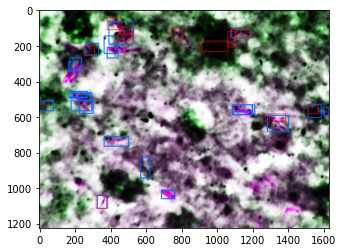

In [8]:
z=0
path_test="DATA_SPLIT/val/photos"
annot_test="DATA_SPLIT/val/anotations"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
c=0
for e,i in enumerate(os.listdir(path_test)):
    if i.startswith("tuberculosis-phone-0032"):
        z += 1
        filename=i.split(".")[0]+".csv"
        img = cv2.imread(os.path.join(path_test,i))
        img=cv2.medianBlur(img,3)

        img[:,:,0] = cv2.equalizeHist(img[:,:,2])
        img[:,:,1] = cv2.equalizeHist(img[:,:,1])
        img[:,:,2] = cv2.equalizeHist(img[:,:,0])

        #border detecion
        #img_grey=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #gauss = cv2.GaussianBlur(img_grey, (5,5), 0)
        #canny = cv2.Canny(gauss, 0, 140)
        #(contornos,_) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #cv2.drawContours(img,contornos,-1,(0,0,255), 2)
        ################

        # Delete Background
        #hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        #lower_bound = np.array([100, 20, 20])   
        #upper_bound = np.array([255, 255, 255])
        # find the colors within the boundaries
        #mask = cv2.inRange(hsv, lower_bound, upper_bound)

        #define kernel size  
        #kernel = np.ones((3,3),np.uint8)
        # Remove unnecessary noise from mask
        #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        # Segment only the detected region
        #segmented_img = cv2.bitwise_and(img, img, mask=mask)

        # Find contours from the mask
        #contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #img = cv2.drawContours(segmented_img, contours, -1, (0, 0, 255), 2)
        
        #cv2.drawContours(img,contornos,-1,(0,0,255), 2)

        ##############

        df=pd.read_csv(os.path.join(annot_test,filename))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        #img=img/255
        imout = img.copy()
        
        for e,result in enumerate(ssresults):
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            if out[0][0] > 0.6:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 100, 255), 3, cv2.LINE_AA)
                c+=1
            if(e>1000):
                break

        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2]) 
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(imout,(x1,y1),(x2,y2),(255,0,0), 2, cv2.LINE_AA)
        
        plt.imshow(imout)
        plt.show()

Code ccell for training different models

In [ ]:
X_new=np.load("X_new_prep.npy")
y_new=np.load("y_new_prep.npy")

#a=np.where(y_new==1)
#a=np.array(a)
#index_1=np.random.randint(0,a.size,a.size)

#b=np.where(y_new==0)
#b=np.array(b)

#index_2=np.random.choice(b[0,],a.size)
#index=np.concatenate((index_1,index_2))

#X_new=X_new[index]
#X_new.shape
#y_new=y_new[index]

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet')
vggmodel.summary()

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(vggmodel.input, predictions)
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.15)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('model_2_level.png')

model_final.save("RCNN_prep.h5")

images_test=np.load("variables/images_eq_level.npy")
labels_test=np.load("variables/labels_eq_level.npy")

predicted_label=[]

for image in range(images_test.shape[0]):
  im = images_test[image]
  img = np.expand_dims(im, axis=0)
  out= model_final.predict(img)

  if out[0][0] > 0.7:
      predicted_label.append(1)
  else:
      predicted_label.append(0)

prediction=np.array(predicted_label)

confusion_matrix(labels_test,prediction)


## Thresholding test

In [ ]:
# convert to hsv colorspace
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# lower bound and upper bound for Green color
lower_bound = np.array([65, 0, 50])   
upper_bound = np.array([200, 150, 255])
# find the colors within the boundaries
mask = cv2.inRange(hsv, lower_bound, upper_bound)


#define kernel size  
kernel = np.ones((7,7),np.uint8)
# Remove unnecessary noise from mask
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Segment only the detected region
segmented_img = cv2.bitwise_and(img, img, mask=mask)

# Find contours from the mask
contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(segmented_img, contours, -1, (0, 0, 255), 3)
# Showing the output
plt.imshow(output)
plt.show()

rgbimg = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

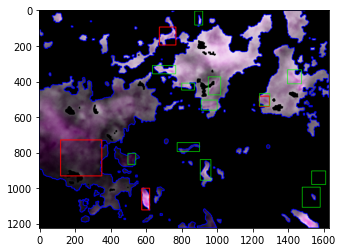

In [40]:
z=0
path_test="DATA_SPLIT/val/photos"
annot_test="DATA_SPLIT/val/anotations"

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
c=0
for e,i in enumerate(os.listdir(path_test)):
    if i.startswith("tuberculosis-phone-0393"):
        z += 1
        filename=i.split(".")[0]+".csv"
        img = cv2.imread(os.path.join(path_test,i))
        #img=cv2.medianBlur(img,3)
        img[:,:,0] = cv2.equalizeHist(img[:,:,2])
        img[:,:,1] = cv2.equalizeHist(img[:,:,1])
        img[:,:,2] = cv2.equalizeHist(img[:,:,0])

        # convert to hsv colorspace
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # lower bound and upper bound for Green color
        #lower_bound = np.array([130, 0, 70])   
        #upper_bound = np.array([170, 250, 255])
        lower_bound = np.array([100, 20, 20])   
        upper_bound = np.array([255, 255, 255])
        # find the colors within the boundaries
        mask = cv2.inRange(hsv, lower_bound, upper_bound)


        #define kernel size  
        kernel = np.ones((7,7),np.uint8)
        # Remove unnecessary noise from mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

        # Segment only the detected region
        segmented_img = cv2.bitwise_and(img, img, mask=mask)

        # Find contours from the mask
        contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img = cv2.drawContours(segmented_img, contours, -1, (0, 0, 255), 3)

        #img = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)            

        df=pd.read_csv(os.path.join(annot_test,filename))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        #img=img/255
        imout = img.copy()

        for e,result in enumerate(ssresults):
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model_final.predict(img)
            if out[0][0] > 0.7:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 3, cv2.LINE_AA)
                c+=1
            if(e>2000):
                break

        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(imout,(x1,y1),(x2,y2),(0,255,0), 2, cv2.LINE_AA)
        
        plt.figure()
        plt.imshow(imout)